In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
pd.options.display.max_colwidth = 200

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train.json to train.json


In [0]:
df = pd.read_json('train.json')
print(df.shape)
df.head()

(39774, 3)


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam m..."


In [0]:
# Get the ingredients column from the df data and create the list of all existing ingredients
ingredients = df.ingredients
rawlist=[item for sublist in ingredients.ravel() for item in sublist] #convert the ingredients list of lists into a list
ingredients=list(set(rawlist)) #remove duplicates

for ing in ingredients:
    vector=[]
    # loop for df data
    for recipe in df.ingredients: 
        if ing in recipe:
            vector.append(1)
        else:
            vector.append(0)
    df[ing]=pd.Series(vector,index=df.index) # Adds column containing 0 and 1's for this ingredient
      
# useless columns removal
df=df.drop('ingredients',1)
df=df.drop('id',1)

print(df.shape)
df.head()

(39774, 6715)


,cuisine,devil's food cake mix,shiro miso,fudge brownie mix,pitas,lily flowers,Red Gold® diced tomatoes,sauce mix,slivered almonds,rotisserie chicken,soaking liquid,smoked trout fillets,soft-boiled egg,asian pear,moonshine,yucca,kielbasa (not low fat),steamer,proscuitto,Italian cheese blend,roasted white sesame seeds,unsalted beef stock,black pudding,pak choi,knorr homestyl stock beef,kewra water,kiwi,chicken thigh fillets,hot chili paste,speck,porter,lamb seasoning,Knorr Fish Stock Cubes,pears,graham cracker pie crust,ramen noodles,semolina,plain yogurt,rice mix,2% milk shredded mozzarella cheese,...,all purpose unbleached flour,yellow heirloom tomatoes,light rum,low sodium garbanzo beans,cactus,hellmann' or best food real mayonnais,blue cheese,japanese breadcrumbs,perciatelli,fresh lima beans,rice stick noodles,sandwich rolls,oatmeal,forest fruit,goose liver,chile colorado,rosewater,horseradish sauce,bread ciabatta,strong white bread flour,pork stew meat,creamy peanut butter,millet flour,McCormick Taco Seasoning,Alfredo sauce,liverwurst,crisco,fettuccine pasta,less sodium reduced fat ham,pork lard,fresh mexican cheese,sugar pearls,wasabe,chicken bones,culantro,king prawns,ripe olives,chees fresco queso,flavored oil,swiss chard
0,greek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,southern_us,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,filipino,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,indian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,indian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Split df into train & test
train, test = train_test_split(df, train_size=0.80, test_size=0.20, stratify=df['cuisine'], random_state=42)
train.shape, test.shape

((31819, 6715), (7955, 6715))

In [0]:
# Arrange data into X features matrix and y target vector
target = 'cuisine'
X_train=train.drop(columns=target)
y_train=train[target]
X_test=test.drop(columns=target)
y_test=test[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31819, 6714), (31819,), (7955, 6714), (7955,))

### Begin with baselines for classification

In [0]:
train[target].value_counts(normalize=True)

italian         0.197052
mexican         0.161853
southern_us     0.108614
indian          0.075489
chinese         0.067193
french          0.066533
cajun_creole    0.038876
thai            0.038688
japanese        0.035796
greek           0.029542
spanish         0.024859
korean          0.020868
vietnamese      0.020742
moroccan        0.020648
british         0.020208
filipino        0.018982
irish           0.016782
jamaican        0.013231
russian         0.012288
brazilian       0.011754
Name: cuisine, dtype: float64

### Accuracy with RFC basic Model

In [0]:
pipeline = make_pipeline(RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1))
pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))

Validation Accuracy 0.6587052168447517


### Optimum number of Trees

In [0]:
opt_table_estimators=list()
n_features=5
n_estimators=50
for i in range(1,n_estimators):
    pipeline = make_pipeline(RandomForestClassifier(n_estimators=i,max_features=n_features))
    pipeline.fit(X_train,y_train)
    output=pipeline.predict(X_test)
    opt_table_estimators.append(metrics.accuracy_score(y_test, output))


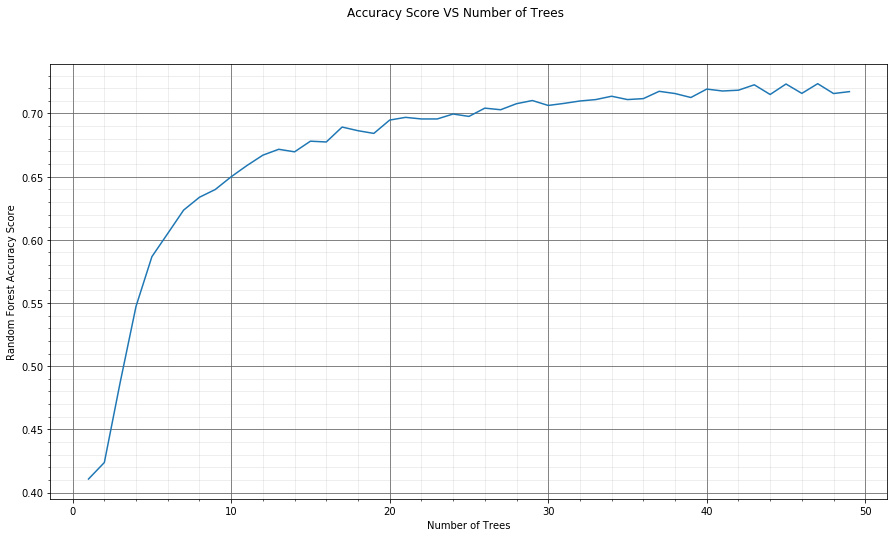

In [0]:
x = range(1,n_estimators)
y = opt_table_estimators
fig, ax = plt.subplots(1, figsize=(15, 8))
fig.suptitle('Accuracy Score VS Number of Trees')
ax.plot(x,y)
plt.xlabel('Number of Trees')
plt.ylabel('Random Forest Accuracy Score')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

### Optimum number of Features

In [0]:
opt_table_n_features=list()
n_estimators=5
n_features=50
for i in range(1,n_features):
    pipeline = make_pipeline(RandomForestClassifier(n_estimators=i,max_features=n_features))
    pipeline.fit(X_train,y_train)
    output=pipeline.predict(X_test)
    opt_table_n_features.append(metrics.accuracy_score(y_test, output))

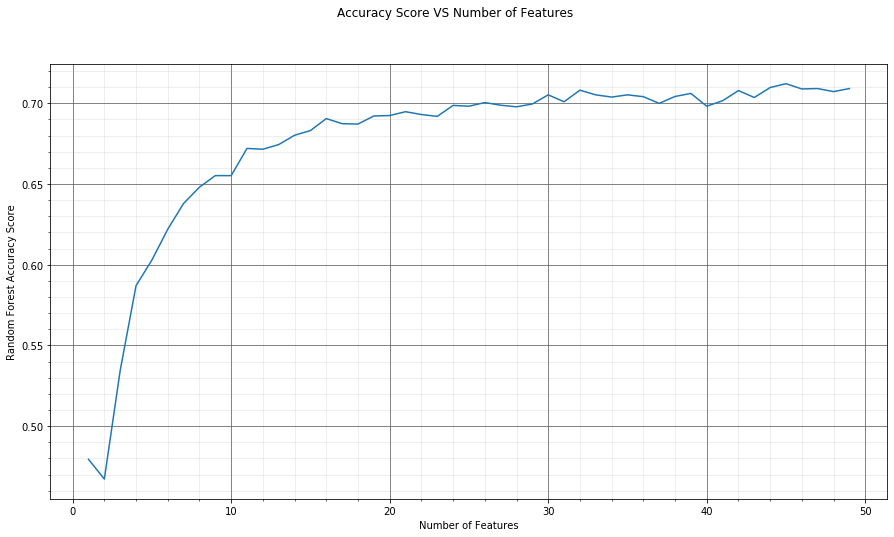

In [0]:
x = range(1,n_features)
y = opt_table_n_features
fig, ax = plt.subplots(1, figsize=(15, 8))
fig.suptitle('Accuracy Score VS Number of Features')
ax.plot(x,y)
plt.xlabel('Number of Features')
plt.ylabel('Random Forest Accuracy Score')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

### RFC model with 40 trees and 45 features

In [0]:
pipeline = make_pipeline(RandomForestClassifier(n_estimators=40,max_features=45))
pipeline.fit(X_train,y_train)
output=pipeline.predict(X_test)
metrics.accuracy_score(y_test, output)

0.7086109365179133

### Feature Importance

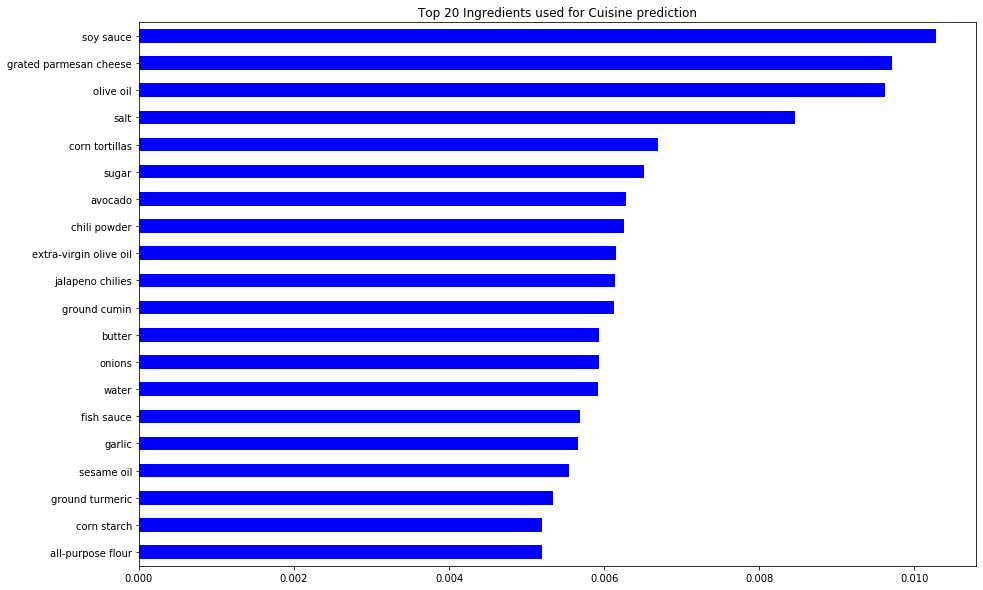

In [0]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
n = 20
plt.figure(figsize=(15,n/2))
plt.title(f'Top {n} Ingredients used for Cuisine prediction')
importances.sort_values()[-n:].plot.barh(color='blue');

### Confusion Matrix

In [0]:
plt.rcParams['figure.figsize'] = [20, 20]

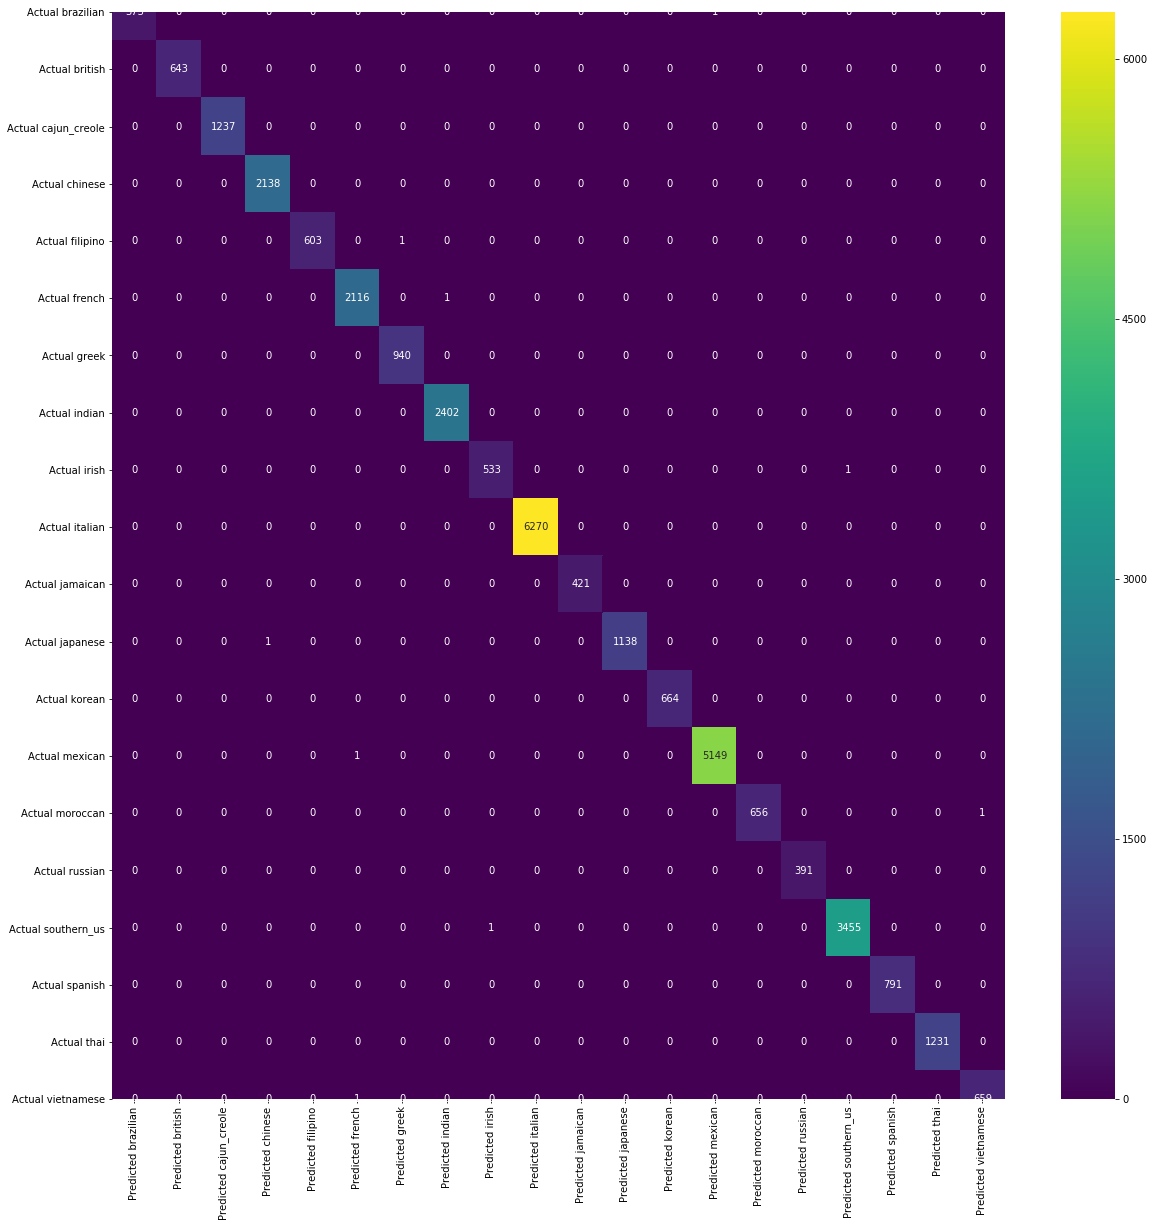

In [0]:
y_pred = pipeline.predict(X_train)
confusion_matrix(y_train, y_pred)
# We need to get labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_test)
# 3. Plot a heatmap
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_train, y_pred);